
## Summary Statistics

1. Total number of chats: 5,729
2. Total code suggestions: 28,072
3. Total code acceptances: 8,867
4. Overall acceptance rate: 31.59%
5. Number of unique languages: 29



<Figure size 1500x600 with 0 Axes>

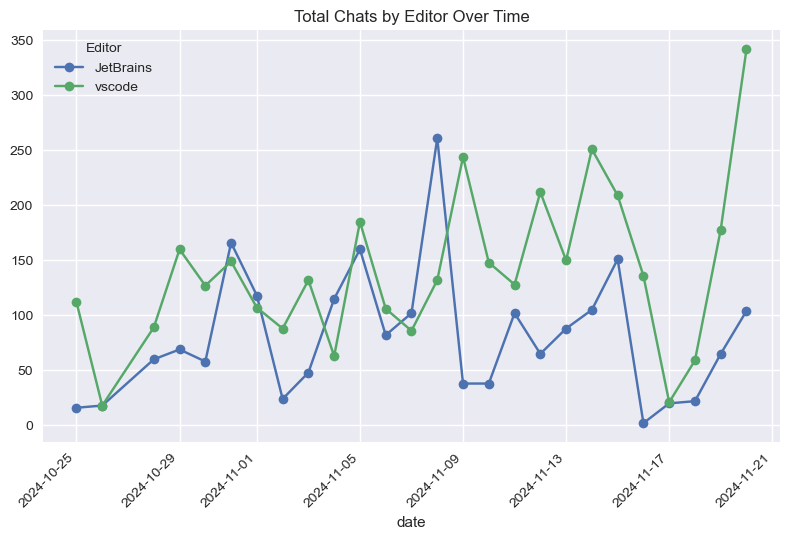

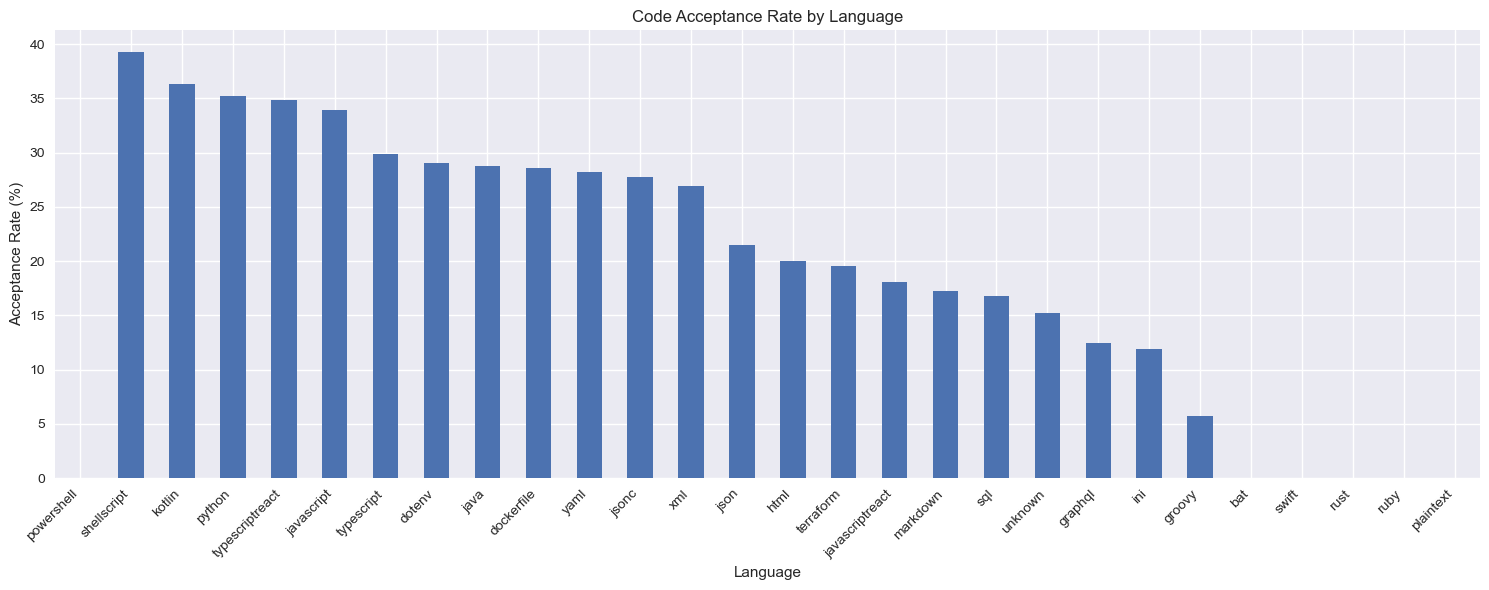

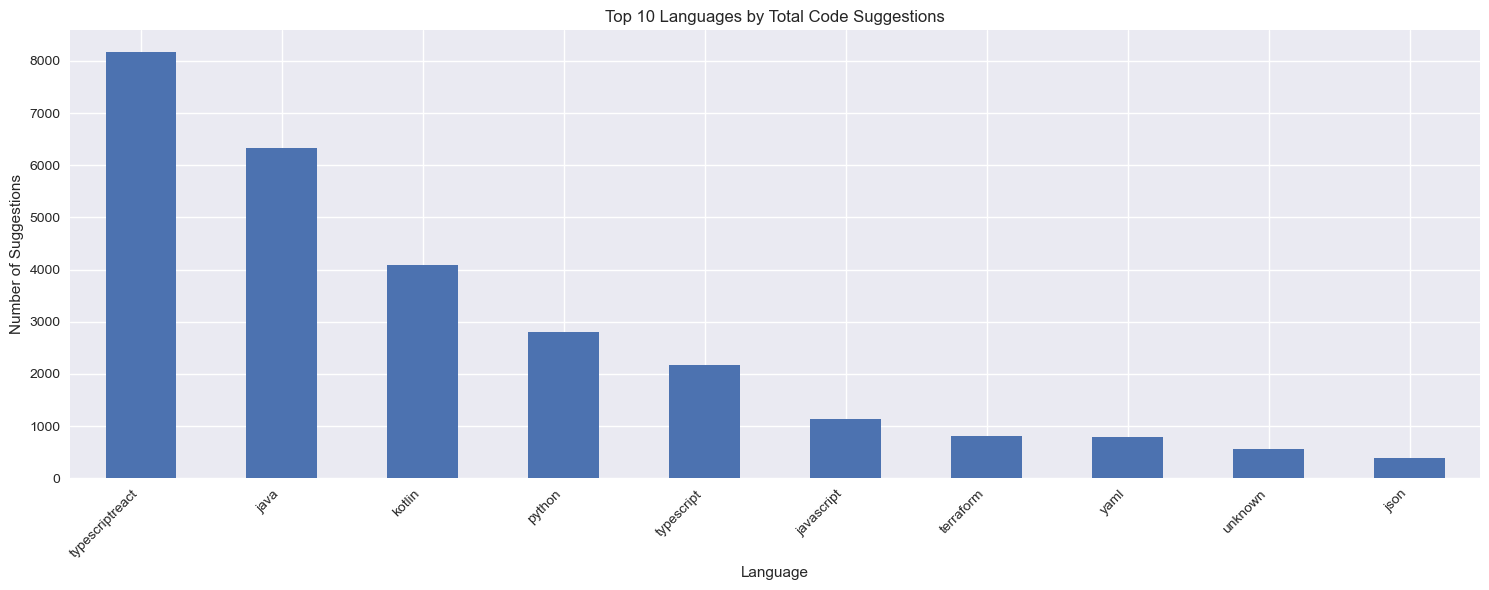

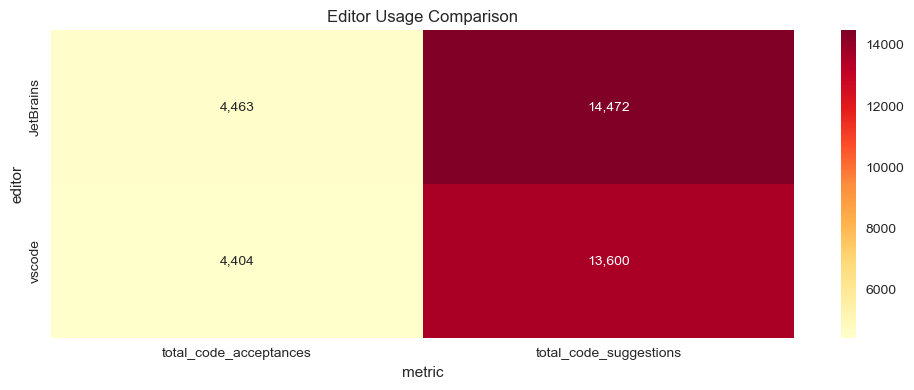

<Figure size 1500x600 with 0 Axes>

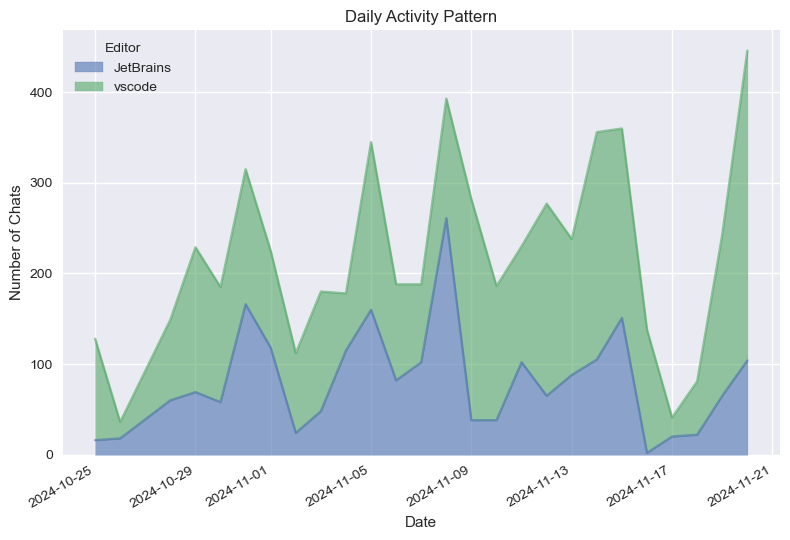

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Read the JSON data
with open('output2.json', 'r') as file:
    json_data = json.load(file)

# Process the data into a format similar to the CSV
records = []

for entry in json_data:
    date = entry['date']
    
    # Process chat data
    if 'copilot_ide_chat' in entry and 'editors' in entry['copilot_ide_chat']:
        for editor in entry['copilot_ide_chat']['editors']:
            for model in editor['models']:
                records.append({
                    'date': date,
                    'editor': editor['name'],
                    'model': model['name'],
                    'metric': 'total_chats',
                    'value': model['total_chats'],
                    'language': ''
                })

    # Process code completion data
    if 'copilot_ide_code_completions' in entry and 'editors' in entry['copilot_ide_code_completions']:
        for editor in entry['copilot_ide_code_completions']['editors']:
            for model in editor['models']:
                if 'languages' in model:
                    for lang in model['languages']:
                        if 'total_code_suggestions' in lang:
                            records.append({
                                'date': date,
                                'editor': editor['name'],
                                'model': model['name'],
                                'metric': 'total_code_suggestions',
                                'value': lang['total_code_suggestions'],
                                'language': lang['name']
                            })
                        if 'total_code_acceptances' in lang:
                            records.append({
                                'date': date,
                                'editor': editor['name'],
                                'model': model['name'],
                                'metric': 'total_code_acceptances',
                                'value': lang['total_code_acceptances'],
                                'language': lang['name']
                            })

# Create DataFrame
df = pd.DataFrame(records)
df['date'] = pd.to_datetime(df['date'])

# Create visualizations
plt.style.use('seaborn')

# 1. Total Chats by Editor Over Time
plt.figure(figsize=(15, 6))
chat_data = df[df['metric'] == 'total_chats'].pivot(index='date', columns='editor', values='value')
chat_data.plot(marker='o')
plt.title('Total Chats by Editor Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='Editor')
plt.tight_layout()

# 2. Code Acceptance Rate by Language
code_suggestions = df[df['metric'] == 'total_code_suggestions'].groupby('language')['value'].sum()
code_acceptances = df[df['metric'] == 'total_code_acceptances'].groupby('language')['value'].sum()
acceptance_rate = (code_acceptances / code_suggestions * 100).round(2)

plt.figure(figsize=(15, 6))
acceptance_rate.sort_values(ascending=False).plot(kind='bar')
plt.title('Code Acceptance Rate by Language')
plt.xlabel('Language')
plt.ylabel('Acceptance Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

# 3. Top Languages by Total Code Suggestions
plt.figure(figsize=(15, 6))
total_suggestions = df[df['metric'] == 'total_code_suggestions'].groupby('language')['value'].sum()
total_suggestions.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Languages by Total Code Suggestions')
plt.xlabel('Language')
plt.ylabel('Number of Suggestions')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

# 4. Editor Usage Comparison (Heatmap)
pivot_data = df[df['metric'].isin(['total_code_suggestions', 'total_code_acceptances'])].pivot_table(
    index='editor',
    columns='metric',
    values='value',
    aggfunc='sum'
)

plt.figure(figsize=(10, 4))
sns.heatmap(pivot_data, annot=True, fmt=',d', cmap='YlOrRd')
plt.title('Editor Usage Comparison')
plt.tight_layout()

# 5. Daily Activity Pattern
daily_activity = df[df['metric'] == 'total_chats'].groupby(['date', 'editor'])['value'].sum().unstack()
plt.figure(figsize=(15, 6))
daily_activity.plot(kind='area', stacked=True, alpha=0.6)
plt.title('Daily Activity Pattern')
plt.xlabel('Date')
plt.ylabel('Number of Chats')
plt.grid(True)
plt.legend(title='Editor')
plt.tight_layout()

# Summary statistics
total_chats = df[df['metric'] == 'total_chats']['value'].sum()
total_suggestions = df[df['metric'] == 'total_code_suggestions']['value'].sum()
total_acceptances = df[df['metric'] == 'total_code_acceptances']['value'].sum()
overall_acceptance_rate = (total_acceptances / total_suggestions * 100) if total_suggestions > 0 else 0

summary_stats = f"""
## Summary Statistics

1. Total number of chats: {total_chats:,}
2. Total code suggestions: {total_suggestions:,}
3. Total code acceptances: {total_acceptances:,}
4. Overall acceptance rate: {overall_acceptance_rate:.2f}%
5. Number of unique languages: {df['language'].nunique()}
"""

print(summary_stats)

# Display all plots
plt.show()